# Les bundles

Nettoyage du champs `acquisition` de `art` pour obtenir la source du don

In [36]:
# Les données sont stockées dans le dossier "data", c'est plus clean
authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')
len(raw_art[raw_art['groupcol'] == ''])

21

In [37]:
# On fusionne les "séries"
art = raw_art.groupby(['groupcol', 'authors', 'acquisition_year', 'acquisition_mode_clean']).first().reset_index()
print(raw_art.shape, art.shape)

(348333, 117) (120902, 117)


In [38]:
def clean_source_string(x):
    y = re.sub(r'(Don de |Donation de |Legs de |Don |Legs |Donation |Dation )', '', x)
    y = re.sub(r'(Achat à |Achat |Achat par commande à )', '', y)
    z = re.sub(r"(le |la |l' |l'|d' |d')", '', y)
    a = re.sub(r'(, \d{4})', '', z)
    b = re.sub(r'(en \d{4})', '', a)
    return b.strip()

In [39]:
def unique_source(x):
    import string
    x.translate(str.maketrans('', '', string.punctuation))
    return x.lower().replace(" ", "")

In [40]:
art['acquisition'] = art['acquisition'].fillna('')
art['source'] = art['acquisition'].apply(clean_source_string)
art['source_clean'] = art['source'].apply(unique_source)

In [41]:
cat_achat = ['Commande', 'Achat']
cat_dons = ['Don', 'Donation', 'Legs']

In [42]:
def clean_source(source):
    if source == "" or source is None:
        return "NA"
    elif re.compile(r'galler|galer').search(source.lower()):
        return "GALLERY"
    elif re.compile(r'artist').search(source.lower()):
        return "ARTIST"
    else:
        return "OTHER"

In [43]:
art['source_category'] = art['source'].apply(clean_source)

In [44]:
art['source_category'].value_counts()

ARTIST     49997
OTHER      32087
NA         25466
GALLERY    13352
Name: source_category, dtype: int64

In [45]:
art['source'] = art.apply(lambda row: row['authors'] if 'ARTIST' in row['source_category']
                          else row['source'], axis=1)

In [46]:
datadons = art[art['acquisition_mode_clean'].isin(cat_dons)].copy()
len(datadons)

24671

In [47]:
datadons['source_category'].value_counts()

OTHER      15372
ARTIST      5793
NA          2907
GALLERY      599
Name: source_category, dtype: int64

In [48]:
datadons = datadons[datadons['source_category'] != 'NA'].copy().reset_index()
art = art[art['source_category'] != 'NA'].copy().reset_index()

In [49]:
def compute_profile(row):
    year = row['acquisition_year']
    source_category = row['source_category']
    source = row['source_clean']
    authors = row['authors']
    collection = row['collection']
    
    # Cas où le don vient de l'artiste : l’artiste A fait don d’une de ses œuvres et...
    if "ARTIST" in source_category:
        
        # Même collection, année, source affiliée, et achat 
        # affiliated_source = art[(art['collection'] == collection)
        #                & (art['source_clean'].isin(list_of_affiliated_galleries))
        #                & (art['acquisition_year'] == year)
        #                & (art['acquisition_mode_clean'].isin(cat_achat))]

        # Même collection, année, artiste, et achat de la part d'un artiste
        same_artist = art[(art['collection'] == collection)
                        & (art['source_category'] == 'ARTIST')
                        & (art['authors'] == authors)
                        & (art['acquisition_year'] == year)
                        & (art['acquisition_mode_clean'].isin(cat_achat))]

        # Même collection, année, artiste, n'importe quelle source non artiste, et achat 
        any_source_same_artist = art[(art['collection'] == collection)
                        & (art['source_category'] != 'ARTIST')
                        & (art['authors'] == authors)
                        & (art['acquisition_year'] == year)
                        & (art['acquisition_mode_clean'].isin(cat_achat))]
        
        # ... personne ne vend rien
        if len(same_artist) == 0 and len(any_source_same_artist) == 0:
            return '1B'
        # ... l'artiste vend au moins une œuvre
        elif len(same_artist) > 0 and len(any_source_same_artist) == 0:
            return '2D'
        # .. une galerie quelconque vend au moins un oeuvre de A
        elif len(same_artist) == 0 and len(any_source_same_artist) > 0:
            return "2E"
        # ... une galerie et l'artiste vendent du A
        elif len(same_artist) > 0 and len(any_source_same_artist) > 0:
            return "2F"
        # ... une galerie affiliée vend un autre artiste que A
        # elif len(affiliated_source) > 0:
        #    return "3B"
        # ... un autre cas de figure se passe
        else:
            return "AUTRE_A"
    
    # Cas où le don vient de la galerie : attention TOUT CE QUI N'EST PAS ARTISTE EST GALERIE
    # la galerie G fait don de l'artiste A et...
    else:
        
        # Même collection, année, source, et achat mais autre artiste
        same_source = art[(art['collection'] == collection)
                        & (art['authors'] != authors)
                        & (art['source_clean'] == source)
                        & (art['acquisition_year'] == year)
                        & (art['acquisition_mode_clean'].isin(cat_achat))]

        # Même collection, année, artiste, et achat d'un artiste
        same_artist = art[(art['collection'] == collection)
                        & (art['authors'] == authors)
                        & (art['source_category'] == 'ARTIST')
                        & (art['acquisition_year'] == year)
                        & (art['acquisition_mode_clean'].isin(cat_achat))]

        # Même collection, année, source, artiste, et achat 
        same_source_same_artist = art[(art['collection'] == collection)
                        & (art['source_clean'] == source)
                        & (art['authors'] == authors)
                        & (art['acquisition_year'] == year)
                        & (art['acquisition_mode_clean'].isin(cat_achat))]
        
        # ... personne ne vend rien
        if len(same_artist) == 0 and len(same_source) == 0 and len(same_source_same_artist) == 0:
            return '1A'
        # ... l'artiste vend au moins une œuvre
        elif len(same_artist) > 0 and len(same_source) == 0 and len(same_source_same_artist) == 0:
            return '2A'
        # .. la galerie vend au moins un oeuvre de A
        elif len(same_artist) == 0 and len(same_source_same_artist) > 0:
            return "2B"
        # ... les deux vendent du A
        elif len(same_artist) > 0 and len(same_source_same_artist) > 0:
            return "2C"
        # ... la galerie vend un autre artiste que A
        elif len(same_source) > 0:
            return "3A"
        # ... un autre cas de figure se passe
        else:
            return "AUTRE_G"

In [50]:
datadons['profiles'] = datadons.apply(compute_profile, axis=1)

In [60]:
pd.concat([datadons['profiles'].value_counts().rename('Tous'),
          datadons[datadons['Gender'] == 'masculin']['profiles'].value_counts().rename('Hommes'),
          datadons[datadons['Gender'] == 'féminin']['profiles'].value_counts().rename('Femmes')],
          axis=1, sort=True)

,Tous,Hommes,Femmes
1A,15102,11903,1619
1B,4643,3776,656
2A,118,102,12
2B,354,293,38
2C,4,3,1
2D,755,567,111
2E,371,303,54
2F,24,22,2
3A,393,316,47


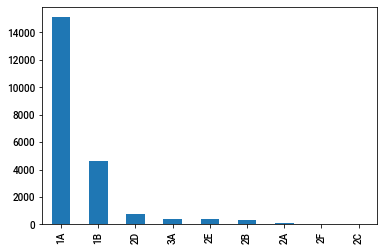

In [52]:
datadons['profiles'].value_counts().plot(kind='bar')

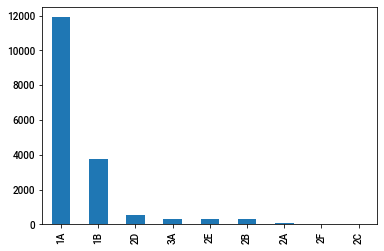

In [53]:
datadons[datadons['Gender'] == 'masculin']['profiles'].value_counts().plot(kind='bar')

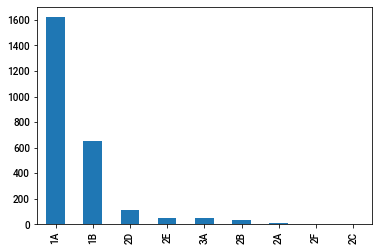

In [54]:
datadons[datadons['Gender'] == 'féminin']['profiles'].value_counts().plot(kind='bar')